## Setting

In [ ]:
!pip install xgboost lightgbm catboost -U

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 7.0 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import sys
import os
import pickle
import pandas as pd
import numpy as np

In [ ]:
root = "/content/drive/MyDrive/Machine Learning/"
sys.path.append(root)
sys.path.append(os.getcwd())

In [ ]:
from sklearn.model_selection import cross_val_score, StratifiedKFold
from close.train_tuning import Model
from close.evaluation import show_confusion_matrix, per_class_accuracy, overall_metrics, top_k_accuracy, confidence_analysis


In [ ]:
is_binary = False
use_original_data = False
pd.set_option("display.max_colwidth", None)
pd.set_option("display.max_columns", None)
pd.set_option("display.width", None)

## Loading Data

In [ ]:
# Load the pickle file
print("Loading datafile...")
with open(f"{root}data/preprocess_data_33/close_train_33.pkl", "rb") as f:
    train = pickle.load(f)
    X_train = pd.DataFrame(train["X"])
    X_train.columns = train["feature_names"]
    y_train = train["y"]
with open(f"{root}data/preprocess_data_33/close_val_33.pkl", "rb") as f:
    val = pickle.load(f)
    X_val = pd.DataFrame(val["X"])
    X_val.columns = val["feature_names"]
    y_val = val["y"]

if use_original_data:
  X_train = train['scaler'].inverse_transform(train['X'])
  X_train = pd.DataFrame(X_train)
  X_train.columns = train['feature_names']

  X_val = val['scaler'].inverse_transform(val['X'])
  X_val = pd.DataFrame(X_val)
  X_val.columns = val['feature_names']

print("Loading complete.")
print("Training data size:\t", len(X_train))
print("Validation data size:\t", len(X_val))

Loading datafile...
Loading complete.
Training data size:	 13300
Validation data size:	 2850


## Model

Logistic Regression

In [ ]:
model_code = "logit"

lr_param_grid = {
    "C": [0.01, 0.1, 1, 10, 100],
    "penalty": ["l2"],
    "solver": ["lbfgs"],
    "max_iter": [2000]
}

### Base Model Training

In [ ]:
mdl = Model(is_binary=is_binary, code=model_code)
mdl.create_model(model_code)
mdl.fit(X_train, y_train)

fi_sorted = mdl.get_feature_importances()
ranked_names = list(fi_sorted.keys())

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [ ]:
k_list = [10, 20, 26, 33]

def make_feature_combinations(ranked_names, k_list):
    combos = []
    for k in k_list:
        real_k = min(k, len(ranked_names))
        combos.append({
            "k": real_k,
            "features": ranked_names[:real_k]
        })
    return combos

feature_combinations = make_feature_combinations(ranked_names, k_list)

In [ ]:
results = []
best_overall_model = None
best_overall_acc = -1
best_overall_features = []

for comb in feature_combinations:
    k = comb["k"]
    feat_names = comb["features"]

    print(f"\n====== Grid Search for LR subset: k={k} ======")
    print("Features:", feat_names)

    X_train_sub = X_train[feat_names]
    X_val_sub   = X_val[feat_names]

    model = Model(is_binary=is_binary)
    model.create_model(model_code)
    print("Using baseline hparams:", model.hparams)

    model.fit(X_train_sub, y_train)

    val_acc = model.score(X_val_sub, y_val)
    print(f"[k={k}] Val Acc = {val_acc:.4f}")

    cv_scores = model.k_fold_cv(X_train_sub, y_train, k=5)

    results.append({
        "k": k,
        "features": feat_names,
        "val_acc": val_acc,
        "cv_mean": np.mean(cv_scores),
        "cv_scores": cv_scores.tolist(),
    })

results_df = pd.DataFrame(results).sort_values(by="val_acc", ascending=False)
print("\n=== Summary (baseline hparams, feature subsets) ===")
print(results_df)


====== Grid Search for LR subset: k=10 ======
Features: ['burst_ratio_in', 'burst_max_first30', 'burst_mean_first30', 'burst_std', 'burst_std_first30', 'burst_mean', 'std_iat_first30', 'mean_iat_first30', 'duration_first30', 'duration']
Using baseline hparams: {'penalty': 'l2', 'C': 1.0}
[k=10] Val Acc = 0.3895
5-fold Cross Validation Scores:	[0.39473684 0.38120301 0.38308271 0.37669173 0.38120301]
5-fold Cross Validation Average Score:	0.3833834586466166

====== Grid Search for LR subset: k=20 ======
Features: ['burst_ratio_in', 'burst_max_first30', 'burst_mean_first30', 'burst_std', 'burst_std_first30', 'burst_mean', 'std_iat_first30', 'mean_iat_first30', 'duration_first30', 'duration', 'switch_count', 'burst_count', 'num_out', 'q75_iat_first30', 'ratio_out', 'frac_in', 'n_packets', 'num_in', 'std_iat', 'burst_ratio_in_first30']
Using baseline hparams: {'penalty': 'l2', 'C': 1.0}


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[k=20] Val Acc = 0.4996


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

5-fold Cross Validation Scores:	[0.5093985  0.49172932 0.50075188 0.50488722 0.49586466]
5-fold Cross Validation Average Score:	0.5005263157894737

====== Grid Search for LR subset: k=26 ======
Features: ['burst_ratio_in', 'burst_max_first30', 'burst_mean_first30', 'burst_std', 'burst_std_first30', 'burst_mean', 'std_iat_first30', 'mean_iat_first30', 'duration_first30', 'duration', 'switch_count', 'burst_count', 'num_out', 'q75_iat_first30', 'ratio_out', 'frac_in', 'n_packets', 'num_in', 'std_iat', 'burst_ratio_in_first30', 'q75_iat', 'switch_count_first30', 'burst_count_first30', 'burst_max', 'median_iat_first30', 'in_first30']
Using baseline hparams: {'penalty': 'l2', 'C': 1.0}


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[k=26] Val Acc = 0.5351


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

5-fold Cross Validation Scores:	[0.54924812 0.52706767 0.54135338 0.53984962 0.53458647]
5-fold Cross Validation Average Score:	0.5384210526315789

====== Grid Search for LR subset: k=33 ======
Features: ['burst_ratio_in', 'burst_max_first30', 'burst_mean_first30', 'burst_std', 'burst_std_first30', 'burst_mean', 'std_iat_first30', 'mean_iat_first30', 'duration_first30', 'duration', 'switch_count', 'burst_count', 'num_out', 'q75_iat_first30', 'ratio_out', 'frac_in', 'n_packets', 'num_in', 'std_iat', 'burst_ratio_in_first30', 'q75_iat', 'switch_count_first30', 'burst_count_first30', 'burst_max', 'median_iat_first30', 'in_first30', 'out_first30', 'ratio_out_first30', 'frac_in_first30', 'mean_iat', 'median_iat', 'q25_iat', 'q25_iat_first30']
Using baseline hparams: {'penalty': 'l2', 'C': 1.0}


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[k=33] Val Acc = 0.5375


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

5-fold Cross Validation Scores:	[0.55150376 0.53308271 0.54097744 0.54097744 0.53984962]
5-fold Cross Validation Average Score:	0.5412781954887219

=== Summary (baseline hparams, feature subsets) ===
    k  \
3  33   
2  26   
1  20   
0  10   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        features  \
3  [burst_ratio_in, burst_max_first30, burst_mean_first30, burst_std, burst_std_first30, burst_mean, std_iat_first30, mean_iat_first30, duration_first30, duration, switch_count, burst_count, num_out, q75_iat_first30, ratio_out, frac_in, n_packets, num_in, std_iat, burst

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


### Feature Evaluation

In [ ]:
mdl.get_feature_importances()

{'burst_ratio_in': -4.694324695325047,
 'burst_max_first30': 4.310229510727988,
 'burst_mean_first30': -3.469126263040427,
 'burst_std': 3.0838602373863657,
 'burst_std_first30': 3.019825855535043,
 'burst_mean': -2.4224862653874695,
 'std_iat_first30': 1.8769941819062057,
 'mean_iat_first30': -1.6446013278086782,
 'duration_first30': -1.6446013278086782,
 'duration': -1.2983126839924595,
 'switch_count': -1.1786381640867707,
 'burst_count': -1.1786381640867707,
 'num_out': 1.1535921399009204,
 'q75_iat_first30': 1.0975280379732766,
 'ratio_out': 1.0291294418145323,
 'frac_in': -1.0291294418145323,
 'n_packets': 0.9762473058235697,
 'num_in': 0.9347630559550562,
 'std_iat': 0.8908086065268387,
 'burst_ratio_in_first30': -0.36786796599198973,
 'q75_iat': -0.29317516068252414,
 'switch_count_first30': 0.28821630354959105,
 'burst_count_first30': 0.28821630354959105,
 'burst_max': 0.2321891810410867,
 'median_iat_first30': -0.22630787801376015,
 'in_first30': 0.05765306993892655,
 'out_fi

### Hyperparameter Tuning

In [ ]:
lr_results = {}

global_best_acc = -1
model_best = None
best_features = None
best_k_val = None

for k in k_list:
    current_comb = [c for c in feature_combinations if c["k"] == k][0]
    feat_names = current_comb["features"]

    print(f"\n{'='*10} GridSearch for k={k} {'='*10}")
    print("Features:", feat_names)

    X_train_sub = X_train[feat_names]
    X_val_sub   = X_val[feat_names]

    model = Model(is_binary=False)
    model.create_model(model_code)

    bst = model.grid_search(X_train_sub, y_train, lr_param_grid, verbose=1)

    best_model  = bst.best_estimator_
    best_params = bst.best_params_
    best_cv     = bst.best_score_
    val_acc     = best_model.score(X_val_sub, y_val)

    print(f"\n=== Result (k={k}) ===")
    print("best_cv_score:", best_cv)
    print("val_acc      :", val_acc)
    print("best_params  :", best_params)

    lr_results[k] = {
        "model": best_model,
        "params": best_params,
        "cv_score": best_cv,
        "val_acc": val_acc
    }

    if val_acc > global_best_acc:
        global_best_acc = val_acc
        model_best = best_model
        best_features = feat_names
        best_k_val = k


========== GridSearch for k=10 ==========
Features: ['burst_ratio_in', 'burst_max_first30', 'burst_mean_first30', 'burst_std', 'burst_std_first30', 'burst_mean', 'std_iat_first30', 'mean_iat_first30', 'duration_first30', 'duration']
Fitting 5 folds for each of 5 candidates, totalling 25 fits
Model type:	Logistic Regression Model
Best score:	0.3967669172932331
Best parameters:	{'C': 10, 'max_iter': 2000, 'penalty': 'l2', 'solver': 'lbfgs'}
Best estimator:	LogisticRegression(C=10, max_iter=2000)

=== Result (k=10) ===
best_cv_score: 0.3967669172932331
val_acc      : 0.4087719298245614
best_params  : {'C': 10, 'max_iter': 2000, 'penalty': 'l2', 'solver': 'lbfgs'}

========== GridSearch for k=20 ==========
Features: ['burst_ratio_in', 'burst_max_first30', 'burst_mean_first30', 'burst_std', 'burst_std_first30', 'burst_mean', 'std_iat_first30', 'mean_iat_first30', 'duration_first30', 'duration', 'switch_count', 'burst_count', 'num_out', 'q75_iat_first30', 'ratio_out', 'frac_in', 'n_packets'

### Evaluation

In [ ]:
print(f"Best Model found at k={best_k_val} with Val Acc={global_best_acc:.4f}")


X_val_best = X_val[best_features]
y = y_val

y_pred = model_best.predict(X_val_best)
y_prob = model_best.predict_proba(X_val_best)

n_classes = len(np.unique(y_train))
class_names = [str(i) for i in range(n_classes)]

Best Model found at k=33 with Val Acc=0.5719


1. Confusion Matrix



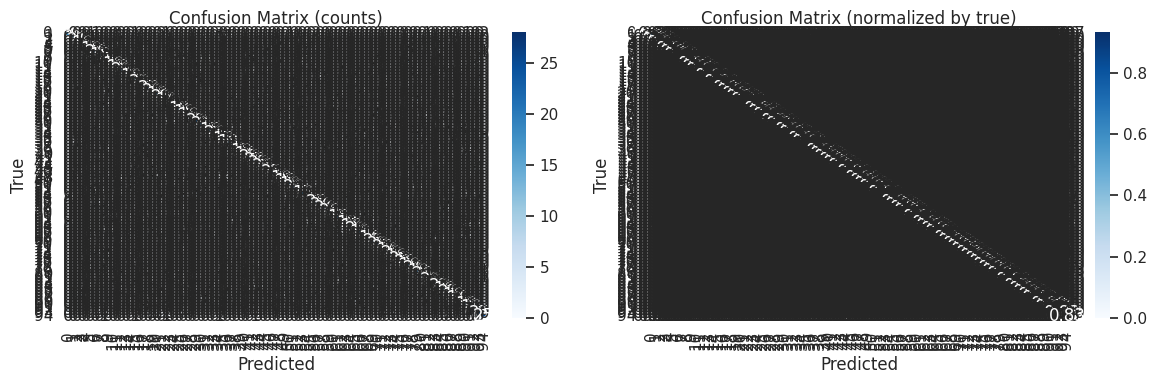

<Figure size 640x480 with 0 Axes>

In [ ]:
cm = show_confusion_matrix(y, y_pred, class_names, model_code)

2. Per-class Accuracy



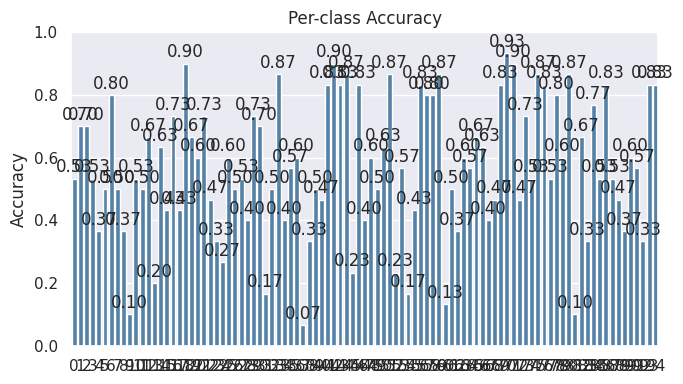

<Figure size 640x480 with 0 Axes>

In [ ]:
per_class_accuracy(cm, class_names, model_code)

In [ ]:
overall_metrics(y, y_pred, y_prob, n_classes)

3. Overall Metrics

- Accuracy: 0.5719
- Macro F1: 0.5602 (macro P=0.5642, macro R=0.5719)
- Weighted F1: 0.5602 (weighted P=0.5642, weighted R=0.5719)
- Log Loss: 1.8128


In [ ]:
top_k_accuracy(y, y_prob, n_classes)

4. Top k Accuracy

- Top-1 accuracy: 0.5719
- Top-3 accuracy: 0.7589
- Top-5 accuracy: 0.8200


5. Confidence Analysis



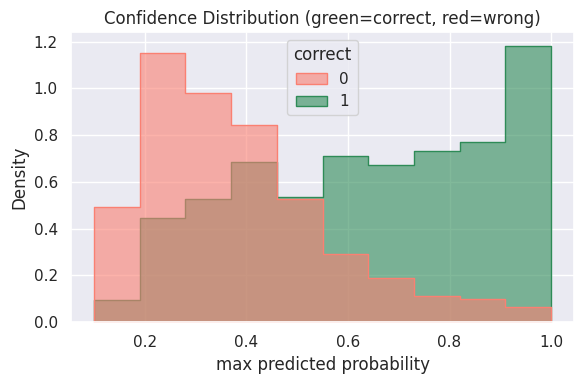

<Figure size 640x480 with 0 Axes>

In [ ]:
confidence_analysis(y, y_pred, y_prob, model_code)

### Save Model

In [ ]:
print(f"Saving best model (k={best_k_val})...")
mdl.save_model(model=model_best, file_name=f"best_lr_k{best_k_val}_{global_best_acc:.4f}")

Saving best model (k=33)...
